In [1]:

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


2025-06-28 08:57:28.425387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751101048.623660      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751101048.675068      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [4]:
TRAINING_DIR='/kaggle/input/pneumonia-polenzo/dataset/chest_xray/train'
TEST_DIR='/kaggle/input/pneumonia-polenzo/dataset/chest_xray/test'
im_shape = (299,299)
seed = 10
BATCH_SIZE = 32

In [5]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")


test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [6]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(200, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

I0000 00:00:1751101091.149352      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751101091.150068      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
epochs = 10

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.keras',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1751101151.190255     119 service.cc:148] XLA service 0x7fd704003cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751101151.191038     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751101151.191059     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751101156.122474     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751101168.550029     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8521 - loss: 2.0684
Epoch 1: val_loss improved from inf to 0.40349, saving model to model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.8524 - loss: 2.0582 - val_accuracy: 0.8311 - val_loss: 0.4035
Epoch 2/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 45s 353ms/step - accuracy: 0.8750 - loss: 0.3326

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.40349 to 0.32239, saving model to model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.8750 - loss: 0.3326 - val_accuracy: 0.8613 - val_loss: 0.3224
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.9362 - loss: 0.1744
Epoch 3: val_loss did not improve from 0.32239
130/130 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9362 - loss: 0.1743 - val_accuracy: 0.8066 - val_loss: 0.4516
Epoch 4/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 40s 311ms/step - accuracy: 0.9688 - loss: 0.0988
Epoch 4: val_loss did not improve from 0.32239
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9688 - loss: 0.0988 - val_accuracy: 0.7998 - val_loss: 0.4618
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.9419 - loss: 0.1413
Epoch 5: val_loss improved from 0.32239 to 0.25533, saving model to model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9419 - loss: 0.1413 - val_accuracy: 0.9043 - val_loss: 0.2553
Epoc

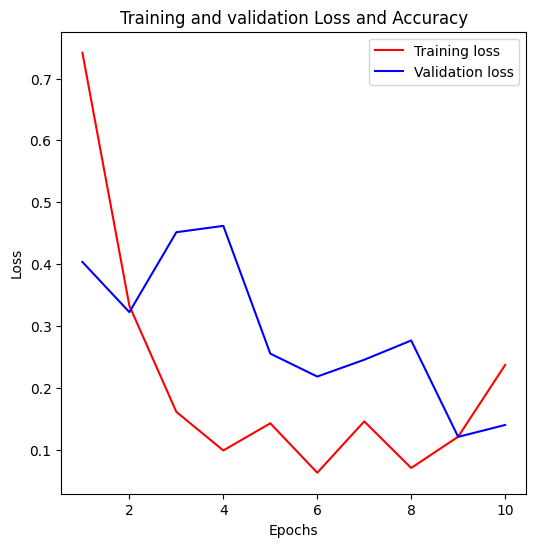

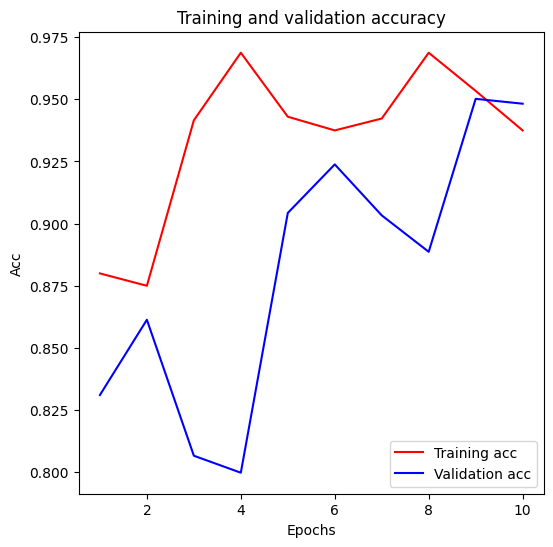

In [8]:

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(6,6))
#plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'r', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('EpochVsLoss.jpg',dpi = 300, bbox_inches='tight')
plt.show()
plt.figure(figsize=(6,6))
#plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'r', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.savefig('EpochVsAcc.jpg',dpi = 300, bbox_inches='tight')
plt.show()

In [9]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 32.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.3 MB/s eta 0:00:00


In [11]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

model = tf.keras.models.load_model('model.keras')  


class_names = ["Normal", "Pneumonia"]  


def preprocess_image(image):
    img = cv2.resize(image, (299, 299))  
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img


def predict(image):
    img_array = preprocess_image(image)
    preds = model.predict(img_array)

    # If sigmoid: preds = [[0.88]]
    # If softmax: preds = [[0.1, 0.9]]
    if preds.shape[1] == 1:
        confidence = float(preds[0][0])
        label = class_names[1] if confidence > 0.5 else class_names[0]
        confidence_display = confidence if confidence > 0.5 else 1 - confidence
    else:
        class_index = int(np.argmax(preds[0]))
        label = class_names[class_index]
        confidence_display = float(np.max(preds[0]))

    return label, f"Confidence: {confidence_display:.2f}"


iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=["text", "text"],
    title="🩺 Pneumonia Detection",
    description="Upload a chest X-ray image. The model will predict whether the image shows signs of Pneumonia or is Normal."
)


iface.launch()

* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://6f32c1eaed2d7dd1f7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
